# Brain Tumor Detection using Tensorflow CNN

## Importing Libraries

In [1]:
import os
import kagglehub
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

## Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

In [3]:
path

'C:\\Users\\Alex\\.cache\\kagglehub\\datasets\\sartajbhuvaji\\brain-tumor-classification-mri\\versions\\2'

In [4]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size = 256
for i in labels:
  folderPath = os.path.join(f'{path}/Training', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
  folderPath = os.path.join(f'{path}/Testing', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 170.07it/s]


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

## Visualizatioin

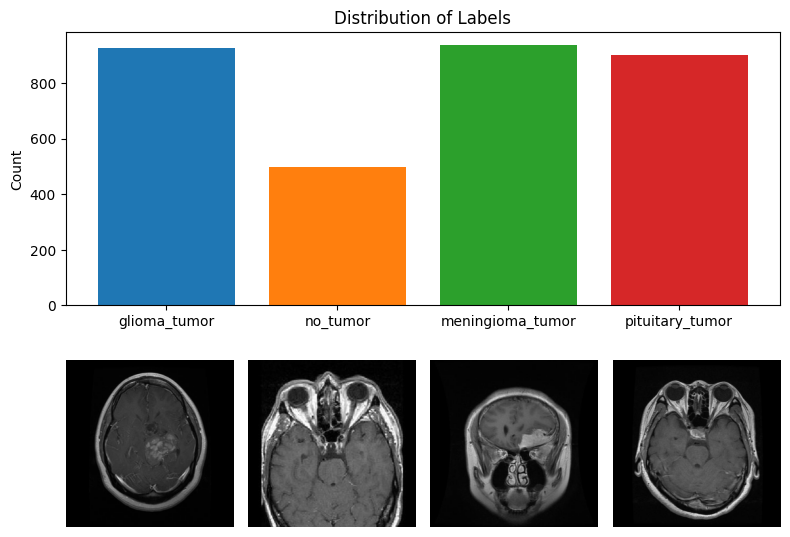

In [7]:
label_counts = {label: np.sum(y_train == label) for label in labels}

plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)

# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

### Glioma: Cancerous brain tumors in glial cells.
### Meningioma: Non-cancerous tumors originating from the meninges.
### No Tumor: Normal brain scans without detectable tumors.
### Pituitary: Tumors affecting the pituitary gland, which can be cancerous or non-cancerous.

## Data augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images by ±20 degrees
    width_shift_range=0.1, # Shift width by 10% of original size
    height_shift_range=0.1, # Shift height by 10% of the original size
    zoom_range=0.1, # Zoom in/out by 10%
    horizontal_flip=False, # Horizontal reflection prohibited
    vertical_flip=False,  # Vertical reflection is prohibited
    fill_mode='nearest') # Fill empty pixels with nearest values

datagen.fit(X_train)

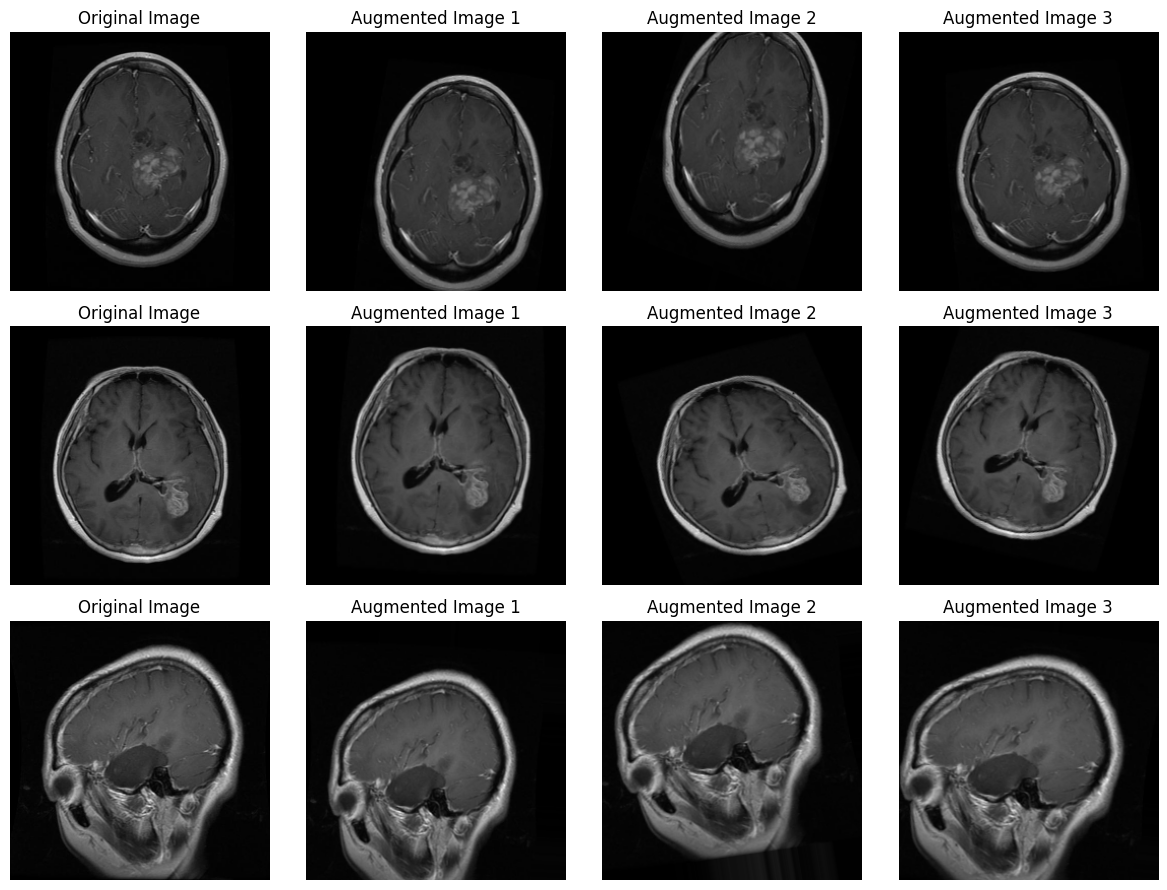

In [9]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:

        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

## Data Preparation

In [8]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

In [9]:
#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_train shape: {(X_test).shape}\n'
      f'y_train shape: {(y_test).shape}\n'
      f'y_train shape: {(X_valid).shape}\n'
      f'X_train shape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_train shape: (327, 256, 256, 3)
y_train shape: (327, 4)
y_train shape: (294, 256, 256, 3)
X_train shape: (294, 4)


## Normalization

In [10]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


## Model with Data Augmentation

In [63]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))   # the Softmax function works for multiclass classification problems
                                            # and the Sigmoid function is a better option for binary-class problems.


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 564,948 (2.16 MB)

 Trainable params: 564,948 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
start_time = time.time()

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_valid, y_valid),
                    epochs=20, verbose=1)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

C:\Users\Alex\Desktop\4th_sem\machine_learning\Presentation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 718ms/step - accuracy: 0.3575 - loss: 1.3785 - val_accuracy: 0.2619 - val_loss: 1.3570
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 709ms/step - accuracy: 0.4090 - loss: 1.3009 - val_accuracy: 0.2517 - val_loss: 1.3745
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 677ms/step - accuracy: 0.4530 - loss: 1.1927 - val_accuracy: 0.4150 - val_loss: 1.2357
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 968ms/step - accuracy: 0.5034 - loss: 1.1325 - val_accuracy: 0.4252 - val_loss: 1.2417
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.5259 - loss: 1.0708 - val_accuracy: 0.4592 - val_loss: 1.1507
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 706ms/step - accuracy: 0.5769 - loss: 1.0088 - val_accuracy: 0.4286 - val_loss: 1.2248
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 728ms/step - accuracy: 0.5658 - loss: 0.9938 - val_accuracy: 0.5374 - val_loss: 1.0070
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step - accuracy: 0.5978 - loss: 0.9347 - val_accu

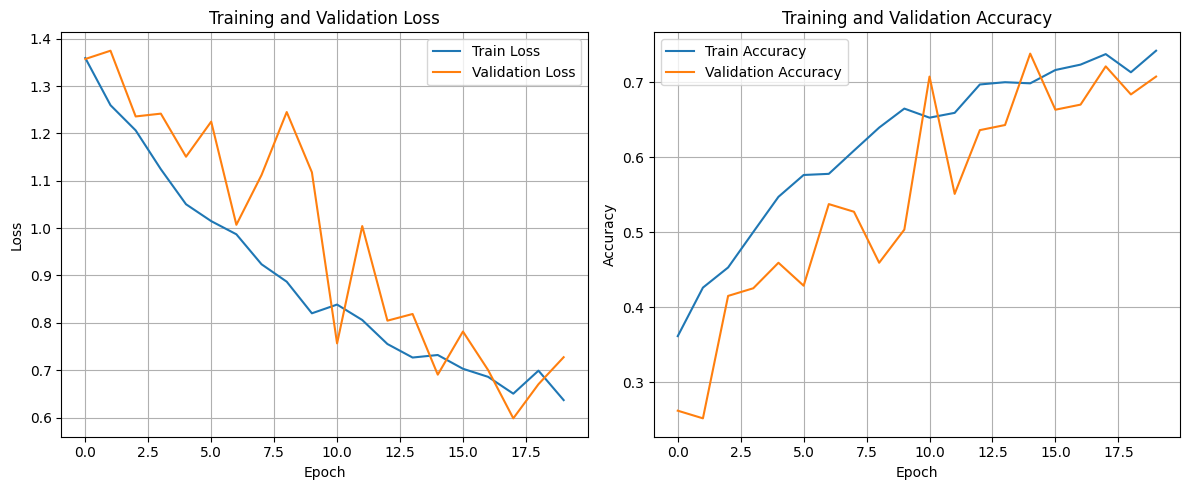

In [65]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [66]:
model.save("my_model_aug.h5")

In [13]:
model = tf.keras.models.load_model("my_model_aug.h5")

## Confusion Matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


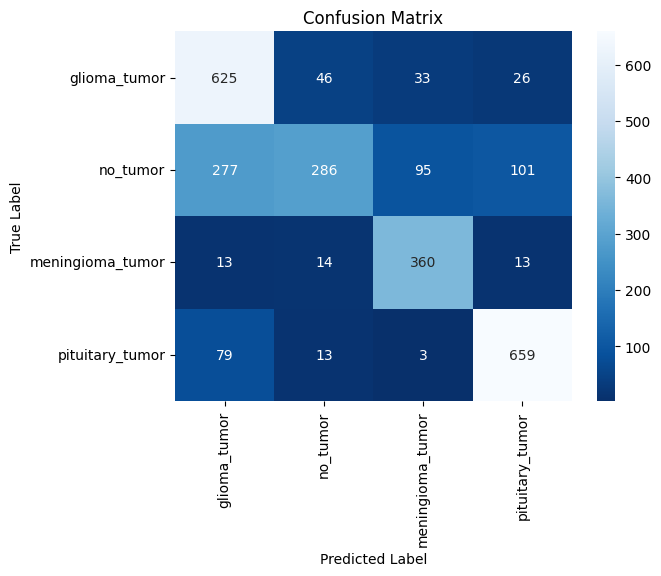

In [68]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


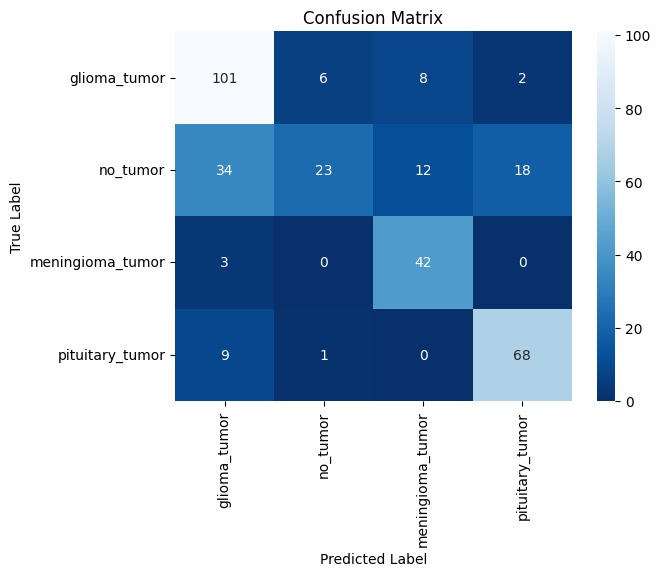

In [69]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluation

In [70]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.86      0.77       117
           1       0.77      0.26      0.39        87
           2       0.68      0.93      0.79        45
           3       0.77      0.87      0.82        78

    accuracy                           0.72       327
   macro avg       0.73      0.73      0.69       327
weighted avg       0.73      0.72      0.68       327



## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted label: no_tumor 
Actual label: glioma_tumor 
Confidence: 59.11%



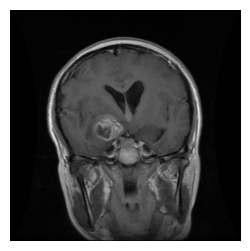

In [15]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

## Model Withought Augmentation

In [72]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

    
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(4, activation='softmax'))


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
start_time = time.time()

history = model.fit(X_train,y_train,validation_split=0.1, epochs =45, verbose=1, batch_size=64)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 884ms/step - accuracy: 0.3704 - loss: 1.3995 - val_accuracy: 0.5132 - val_loss: 1.1022
Epoch 2/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 837ms/step - accuracy: 0.5195 - loss: 1.0948 - val_accuracy: 0.5962 - val_loss: 0.9294
Epoch 3/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 901ms/step - accuracy: 0.6201 - loss: 0.9219 - val_accuracy: 0.6415 - val_loss: 0.8116
Epoch 4/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 939ms/step - accuracy: 0.6662 - loss: 0.8041 - val_accuracy: 0.6830 - val_loss: 0.7483
Epoch 5/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 890ms/step - accuracy: 0.6975 - loss: 0.7379 - val_accuracy: 0.7132 - val_loss: 0.6651
Epoch 6/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 841ms/step - accuracy: 0.7458 - loss: 0.6363 - val_accuracy: 0.7434 - val_loss: 0.5824
Epoch 7/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 821ms/step - accuracy: 0.7715 - loss: 0.5787 - val_accuracy: 0.7925 - val_loss: 0.5096
Epoch 8/45
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 808ms/step - accuracy: 0.7699 - loss: 0.5518 - val_accu

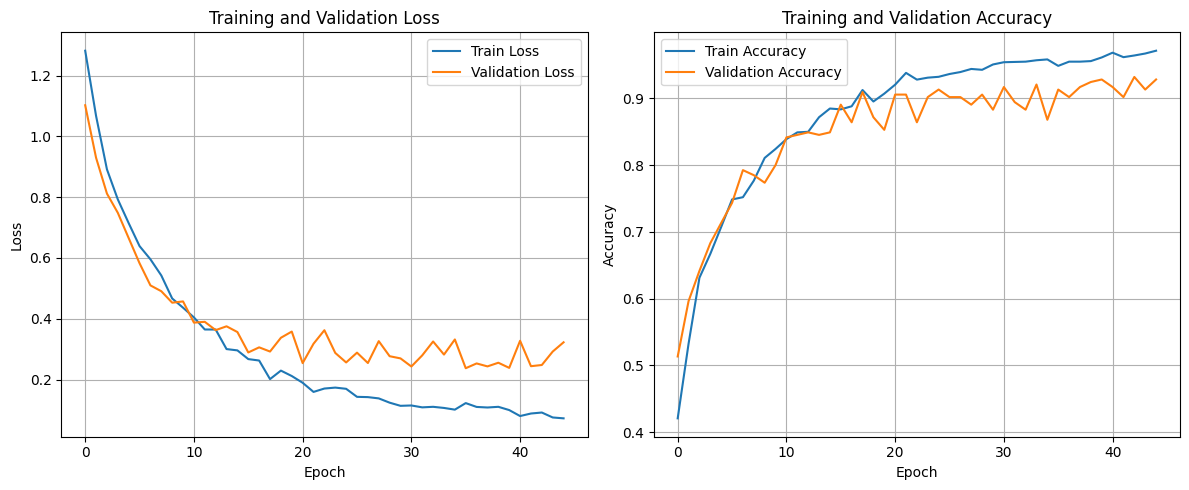

In [74]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [75]:
model.save("my_model_without_aug.h5")

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step


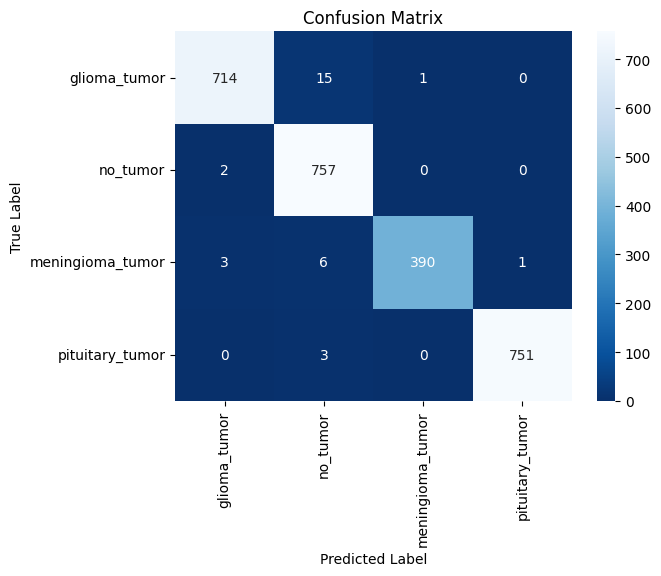

In [76]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step 


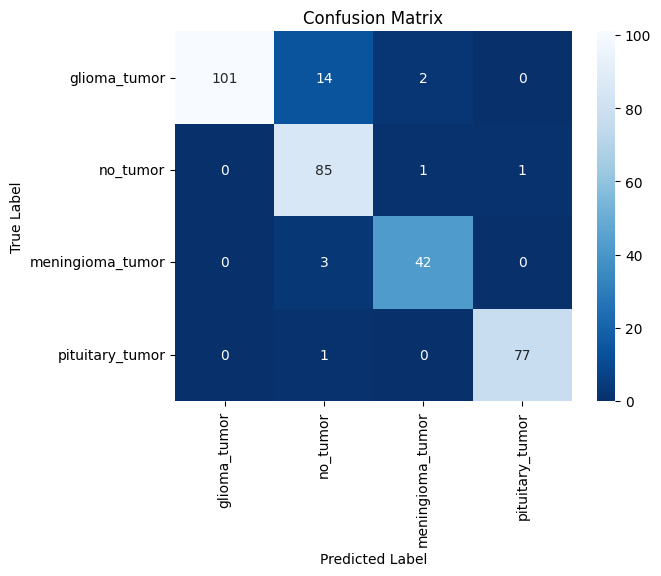

In [77]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Precision: Determines the accuracy of positive predictions by indicating how many of the predicted positive instances are actually positive.

Recall: This metric measures the model's ability to correctly identify all relevant instances, indicating how many actual positive instances were correctly predicted.

F1-score: Represents the harmonic mean of precision and recall, providing a balance between the two, which is especially useful when classes are imbalanced.

Support: Indicates the number of actual occurrences of each class in the dataset, which provides context for calculating precision, recall, and F1 score.

Accuracy: Indicates the overall correctness of the model's predictions by displaying the proportion of correctly predicted instances to the total number of instances.

Macro Avg: Calculates the average precision, recall, and F1-score for all classes, treating each class equally regardless of class imbalance.

Weighted Avg: Calculates the weighted average of precision, recall, and F1-score, with each class's score weighted by its support, providing a more accurate picture of overall model performance, particularly when classes are imbalanced.

In [78]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       117
           1       0.83      0.98      0.89        87
           2       0.93      0.93      0.93        45
           3       0.99      0.99      0.99        78

    accuracy                           0.93       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.94      0.93      0.93       327



In [11]:
model = tf.keras.models.load_model("my_model_without_aug.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


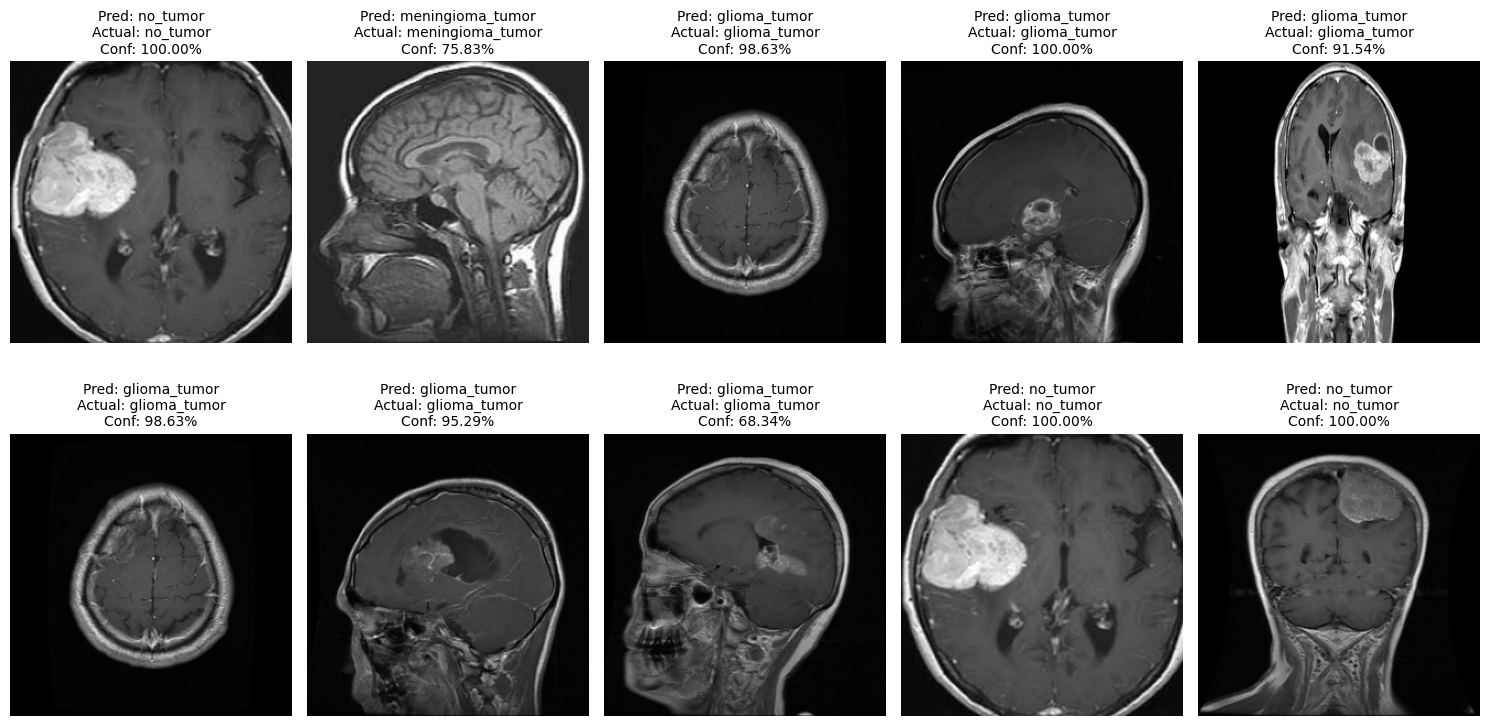


Image 1:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%

Image 2:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 75.83%

Image 3:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 98.63%

Image 4:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 100.00%

Image 5:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 91.54%

Image 6:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 98.63%

Image 7:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 95.29%

Image 8:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 68.34%

Image 9:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%

Image 10:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%


In [12]:
random_indexes = np.random.randint(0, len(X_test), 10)
random_imgs = X_test[random_indexes]
predictions = [model.predict(random_img.reshape(1, 256, 256, 3)) for random_img in random_imgs]  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_classes = [np.argmax(prediction) for prediction in predictions]  # Get the index of the class with the highest probability
predicted_labels = [labels[predicted_class] for predicted_class in predicted_classes]  # Convert class to label
confidences = [prediction[0][predicted_class] for prediction, predicted_class in zip(predictions, predicted_classes)]

actual_indexes = [y_test[random_index] for random_index in random_indexes]  # Get the one-hot encoded actual class
actual_classes = [np.argmax(actual_index) for actual_index in actual_indexes]
actual_labels = [labels[actual_class] for actual_class in actual_classes]

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(random_imgs[i])
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {actual_labels[i]}\nConf: {confidences[i]*100:.2f}%",
              fontsize=10, color='black')
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(f"\nImage {i+1}:")
    print(f"\033[94mPredicted label: {predicted_labels[i]}\033[0m")
    print(f"\033[92mActual label: {actual_labels[i]}\033[0m")
    print(f"\033[93mConfidence: {confidences[i]*100:.2f}%\033[0m")